<a href="https://colab.research.google.com/github/Aryannovice/Stocks_models/blob/main/Multi_LSTM_Real_Time/Mode1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=69660efda773d4a294fe97db5e4963f973c1b79296e60689625545de6f167266
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
!pip install torch-summary
!pip install yfinance

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import yfinance as yf
import torch.optim as optim
import torch.functional as F
from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
from keras.utils import plot_model
from keras.models import Sequential
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout

In [ ]:
tck = yf.Ticker("SI=F")
# defining the start date
start_date = "2016-06-14"
# historical data
df = tck.history(start=start_date, end=None)
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,17.410000,17.410000,17.410000,17.410000,1,0.0,0.0
2016-06-15 00:00:00-04:00,17.490000,17.490000,17.489000,17.489000,1,0.0,0.0
2016-06-16 00:00:00-04:00,17.700001,17.700001,17.254999,17.594000,10,0.0,0.0
2016-06-17 00:00:00-04:00,17.420000,17.455000,17.400000,17.400000,2,0.0,0.0
2016-06-20 00:00:00-04:00,17.445000,17.503000,17.445000,17.503000,3,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-11 00:00:00-05:00,31.115000,31.115000,30.500000,30.540001,69,0.0,0.0
2024-11-12 00:00:00-05:00,30.309999,30.686001,30.309999,30.686001,5,0.0,0.0
2024-11-13 00:00:00-05:00,30.969999,30.969999,30.430000,30.590000,5,0.0,0.0


In [ ]:
# Move column 'Close' to the first position
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,17.410,17.410000,17.410000,17.410000,1,0.0,0.0
2016-06-15 00:00:00-04:00,17.489,17.490000,17.490000,17.489000,1,0.0,0.0
2016-06-16 00:00:00-04:00,17.594,17.700001,17.700001,17.254999,10,0.0,0.0
2016-06-17 00:00:00-04:00,17.400,17.420000,17.455000,17.400000,2,0.0,0.0
2016-06-20 00:00:00-04:00,17.503,17.445000,17.503000,17.445000,3,0.0,0.0


In [ ]:
df.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [ ]:
columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

In [ ]:
df.shape

(2119, 7)

In [ ]:
def check_df(df: object, head: object = 5) -> object:
    print("\nShape")
    print(df.shape)
    print("\nTypes")
    print(df.dtypes)
    print("\nNANs")
    print(df.isnull().sum())
    print("\nInfo")
    print(df.info())
check_df(df)


Shape
(2119, 7)

Types
Close           float64
Open            float64
High            float64
Low             float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

NANs
Close           0
Open            0
High            0
Low             0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2119 entries, 2016-06-14 00:00:00-04:00 to 2024-11-15 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         2119 non-null   float64
 1   Open          2119 non-null   float64
 2   High          2119 non-null   float64
 3   Low           2119 non-null   float64
 4   Volume        2119 non-null   int64  
 5   Dividends     2119 non-null   float64
 6   Stock Splits  2119 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 132.4 KB
None


In [ ]:
df['Volume'] = df['Volume'].astype('float64')

In [ ]:
print('Number of duplicated rows: ' , len(df[df.duplicated()]))

Number of duplicated rows:  2


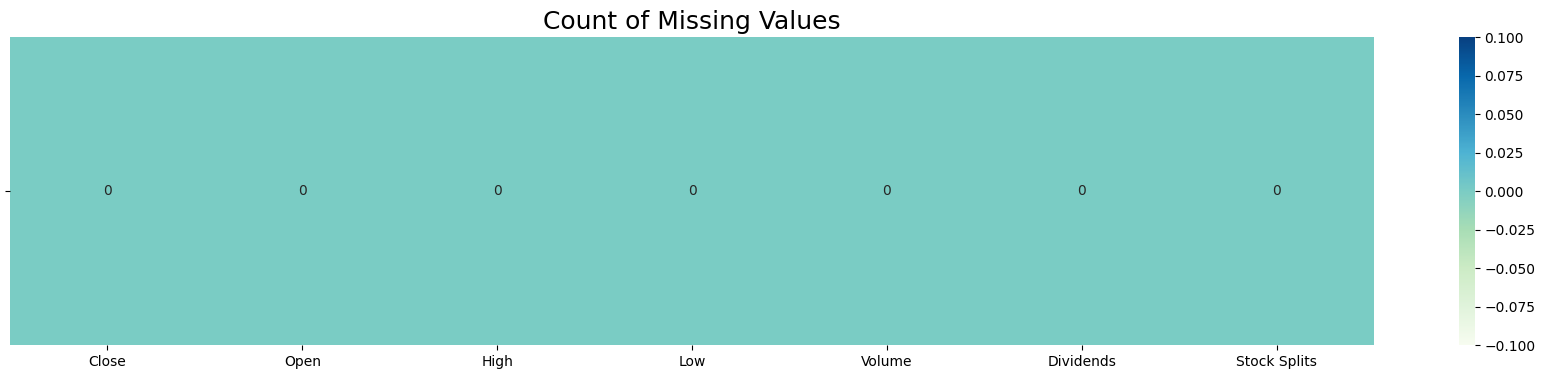

In [ ]:
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [ ]:
df.describe().T.style.background_gradient(cmap='GnBu', axis=1)

,count,mean,std,min,25%,50%,75%,max
Close,2119.000000,20.699867,4.631396,11.735000,16.757000,19.673000,24.193501,34.831001
Open,2119.000000,20.710670,4.631410,12.070000,16.764500,19.690001,24.212500,34.555000
High,2119.000000,20.841232,4.688839,12.205000,16.830000,19.813999,24.327001,34.834999
Low,2119.000000,20.571679,4.574683,11.735000,16.687500,19.497000,24.026501,34.424999
Volume,2119.000000,1817.047664,10532.540239,0.000000,10.000000,42.000000,147.000000,131415.000000
Dividends,2119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Stock Splits,2119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# finding unique data
df.apply(lambda x: len(x.unique()))

,0
Close,1966
Open,1649
High,1737
Low,1723
Volume,531
Dividends,1
Stock Splits,1


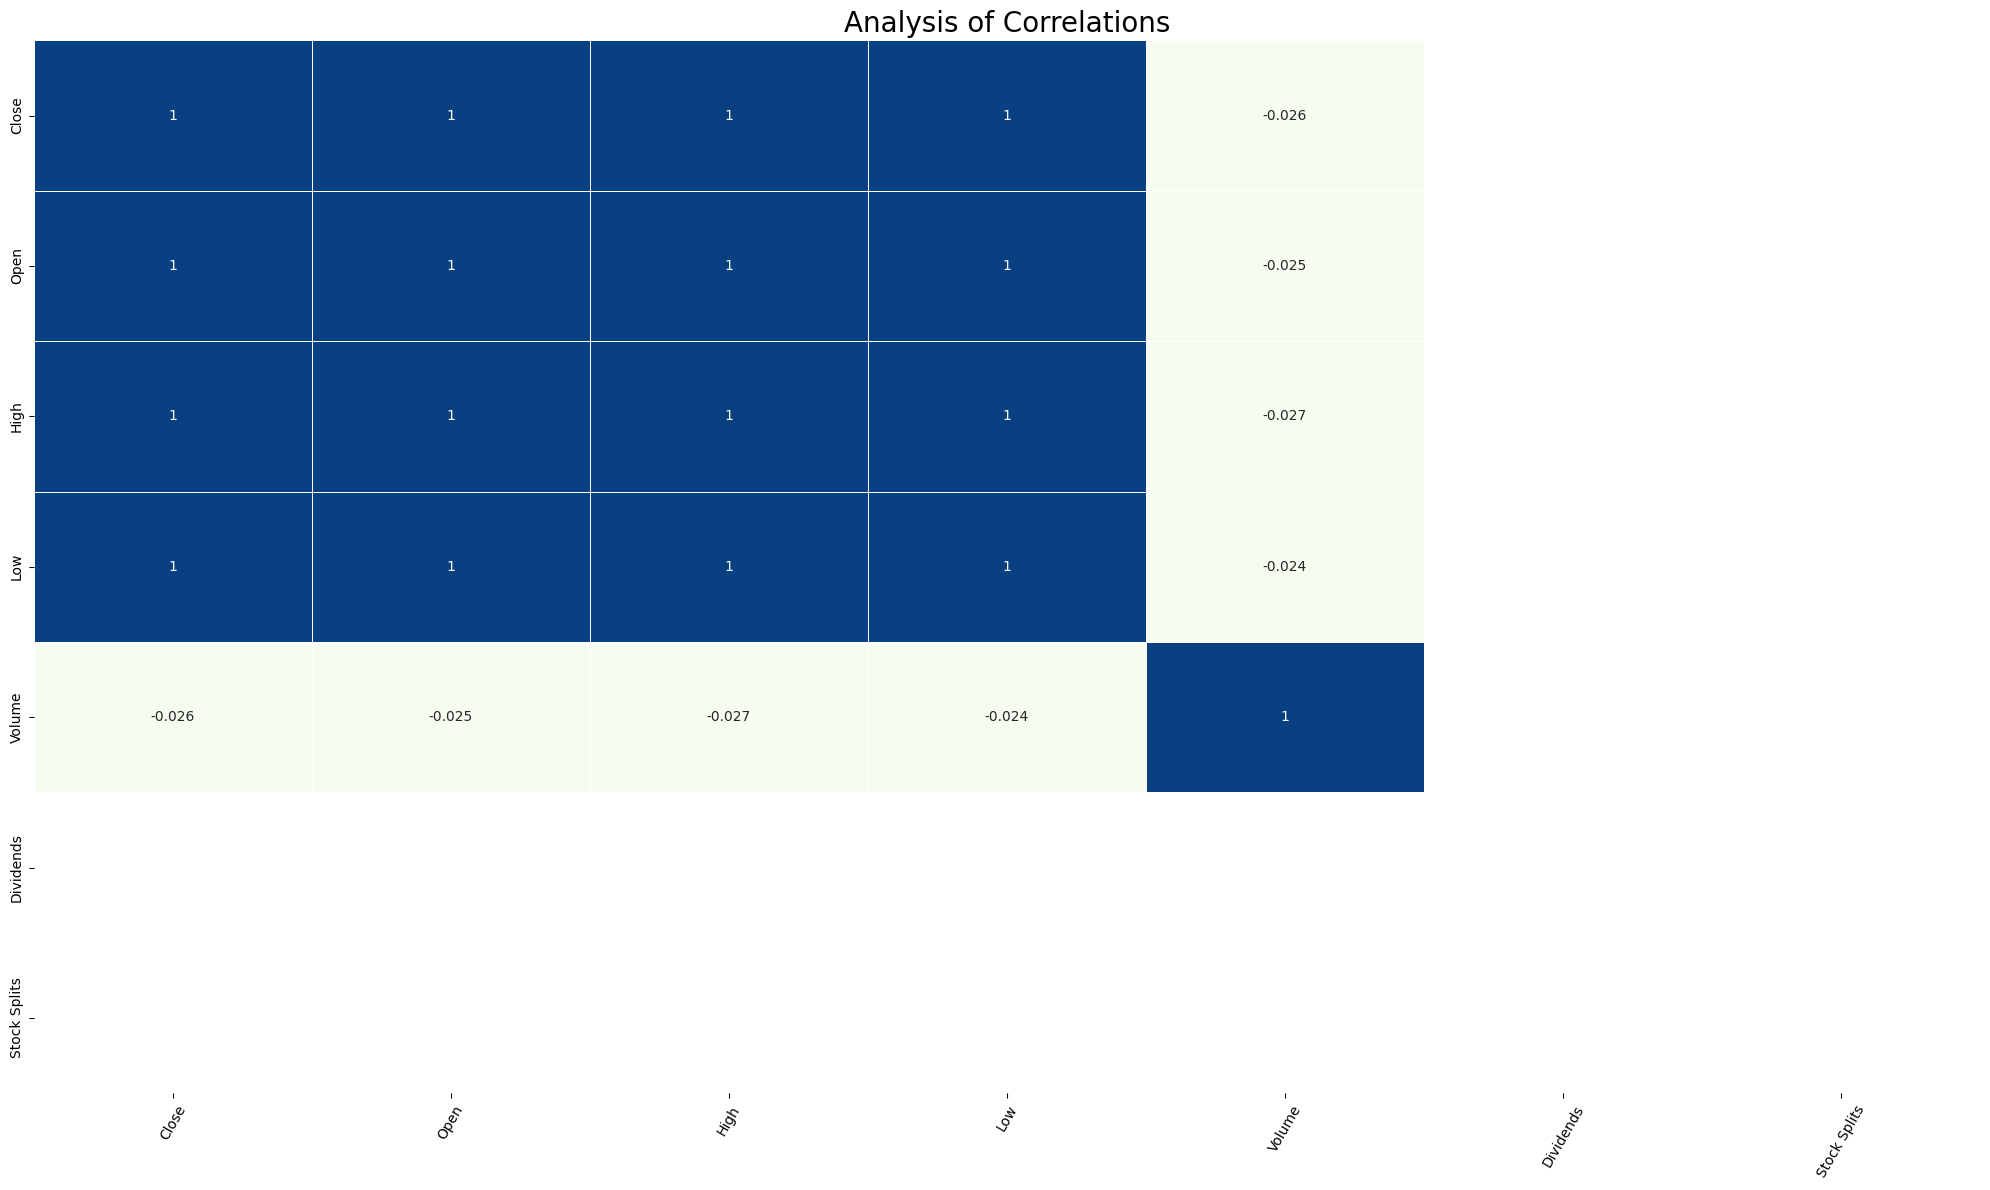

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="GnBu", annot=True, linewidths=.6 , cbar = False)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()

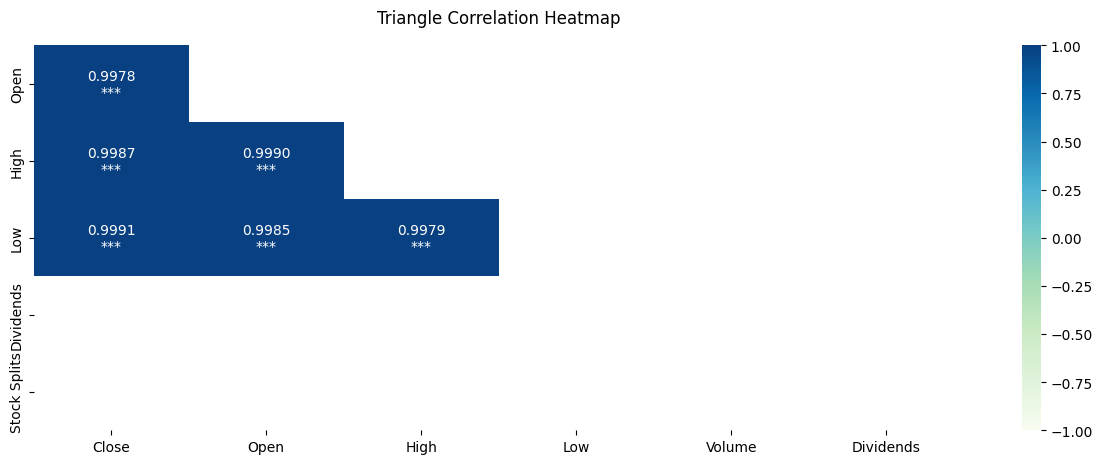

In [ ]:
corr = df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='GnBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 12}, pad=16)
plt.show()

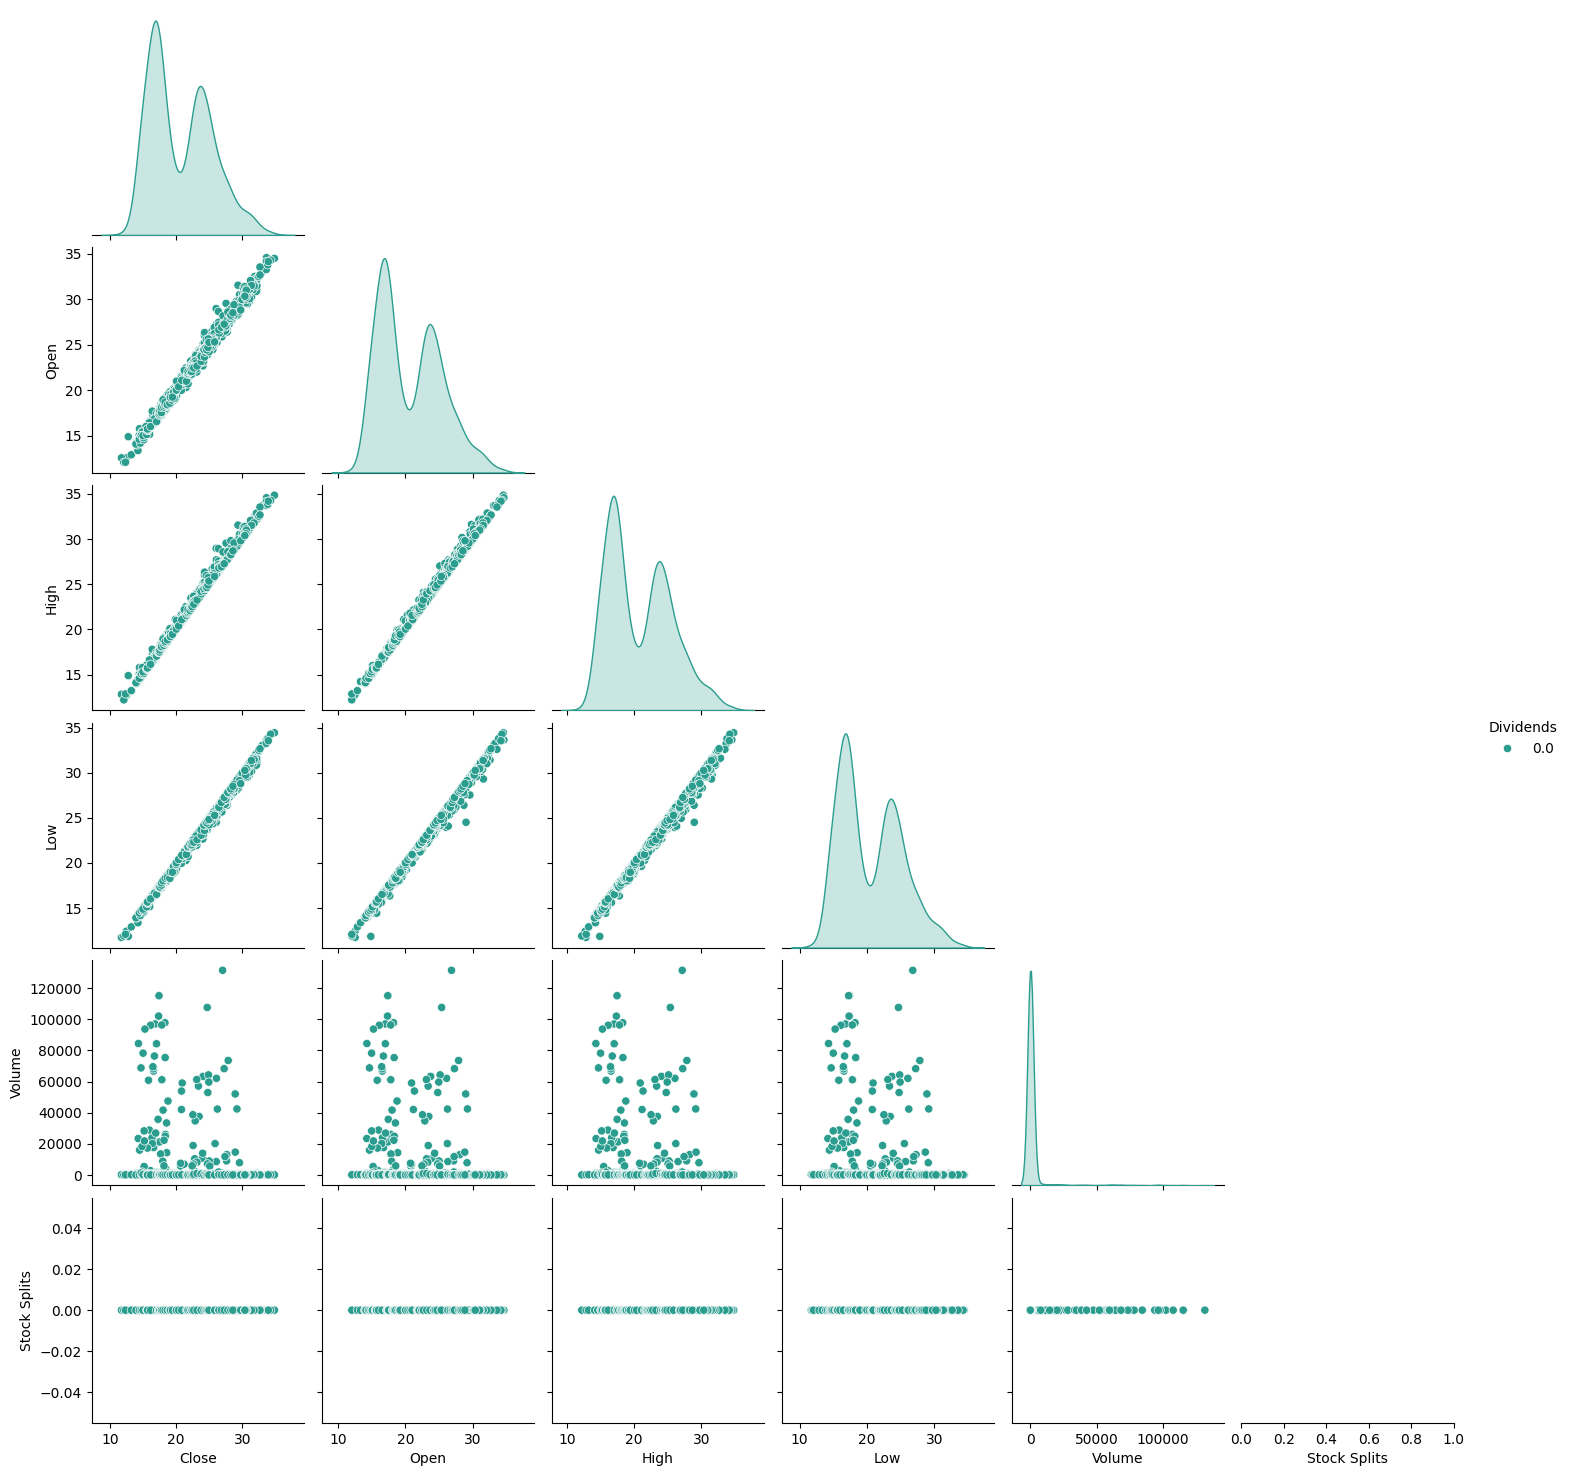

In [ ]:
import warnings
warnings.filterwarnings('ignore')
custom_palette = sns.color_palette(['#2a9d8f', '#f4a261'])
sns.pairplot(data=df, diag_kind='kde', hue='Dividends', palette=custom_palette,corner=True)
plt.gcf().set_facecolor('#ffffff')
plt.show()

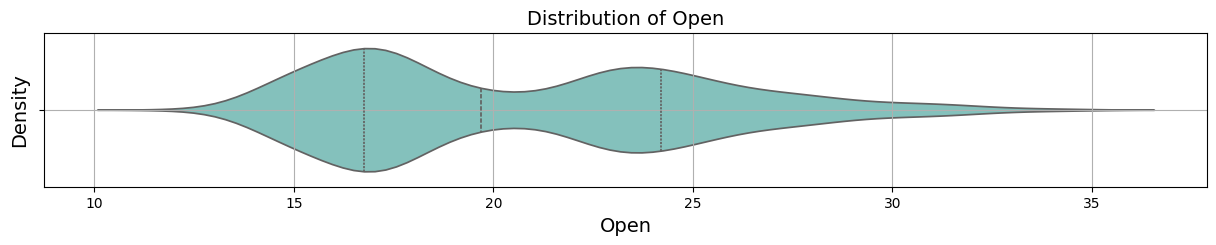

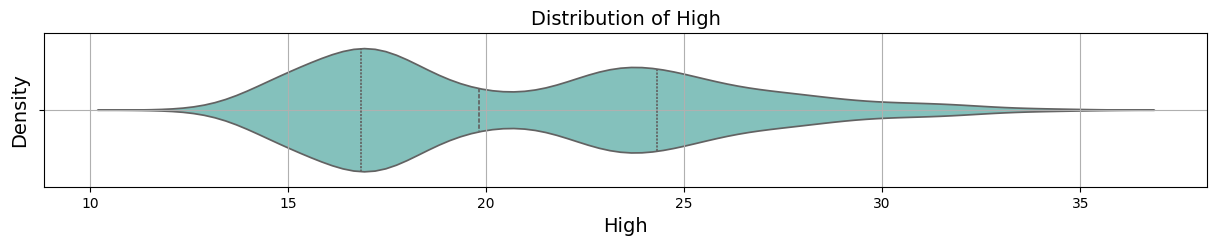

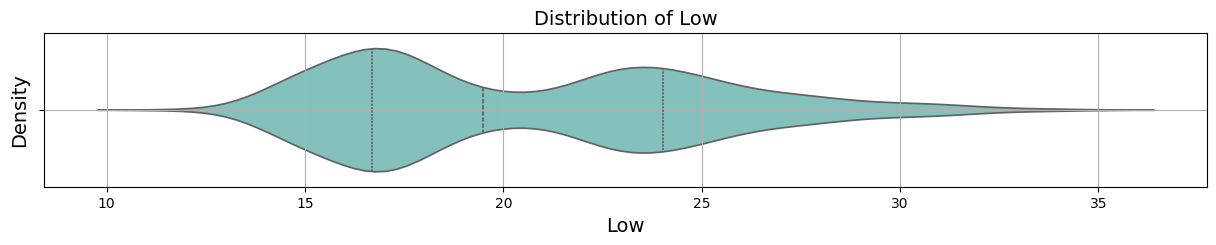

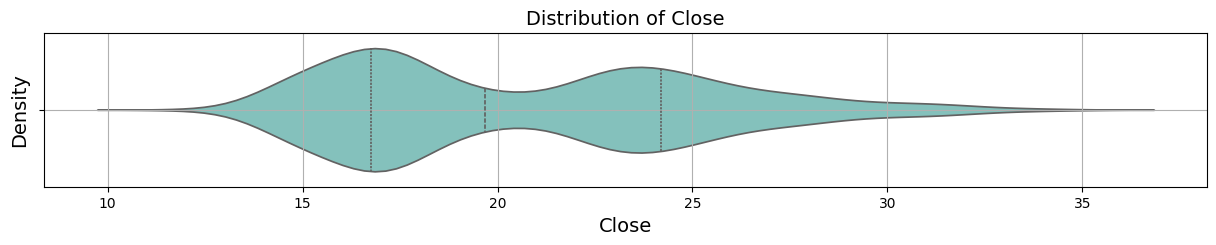

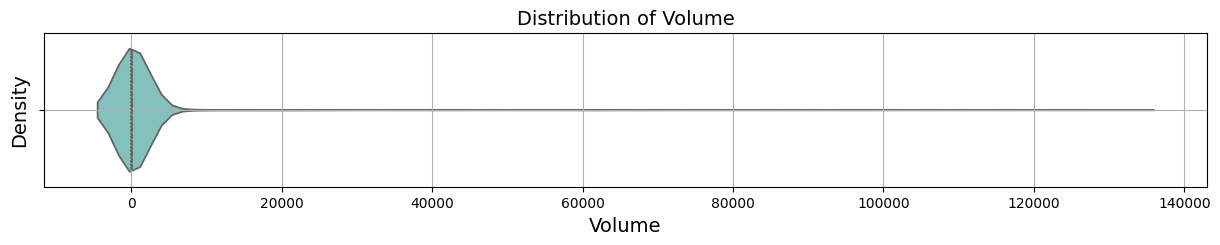

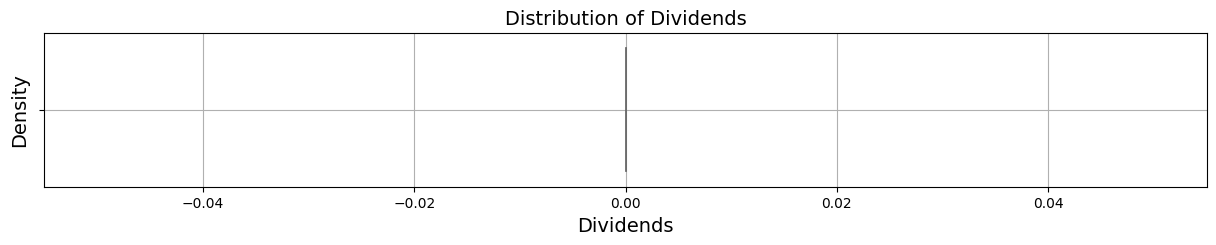

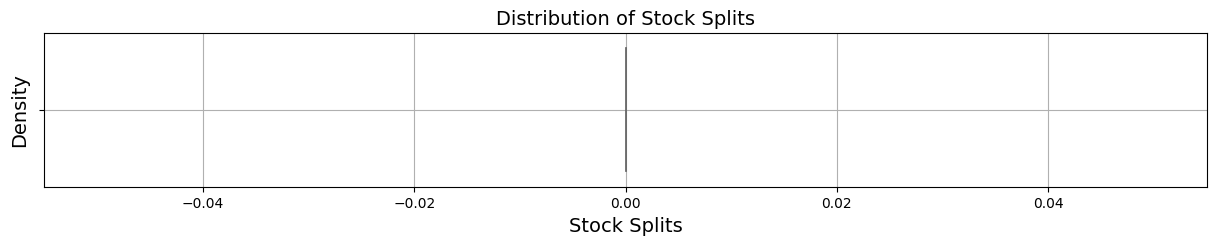

In [ ]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2))
    sns.violinplot(x=df[column], palette=palette, inner="quartile")
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()

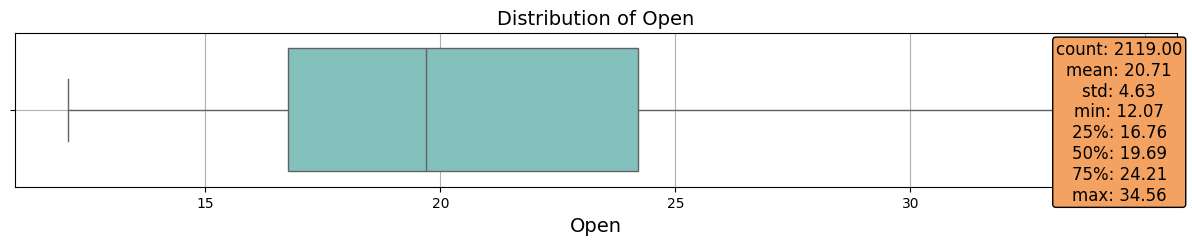

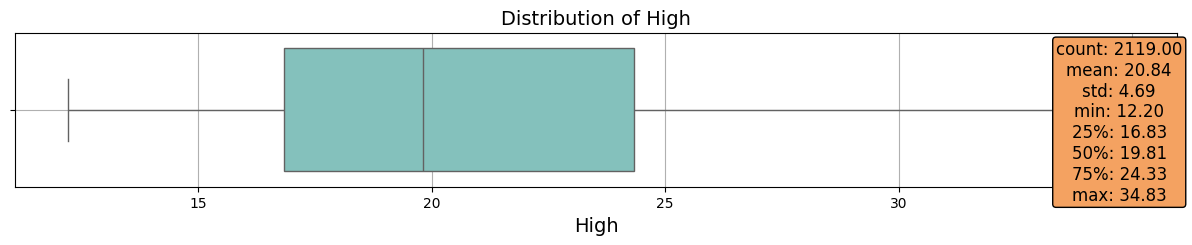

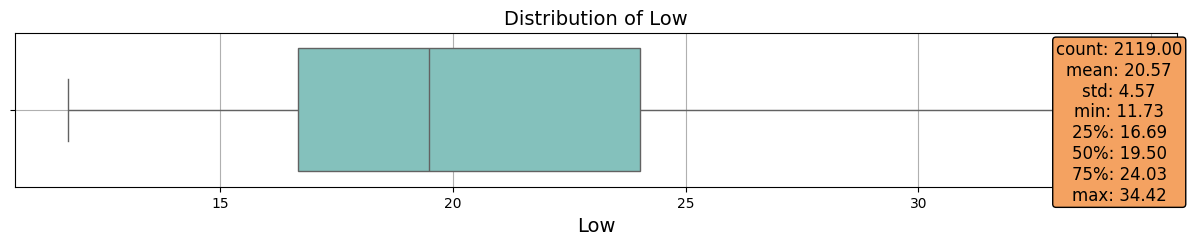

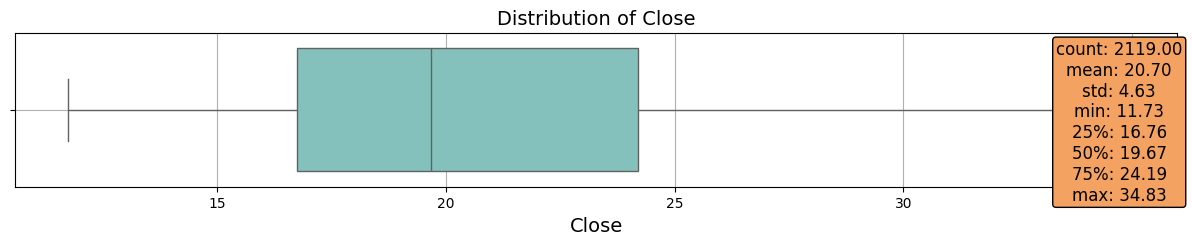

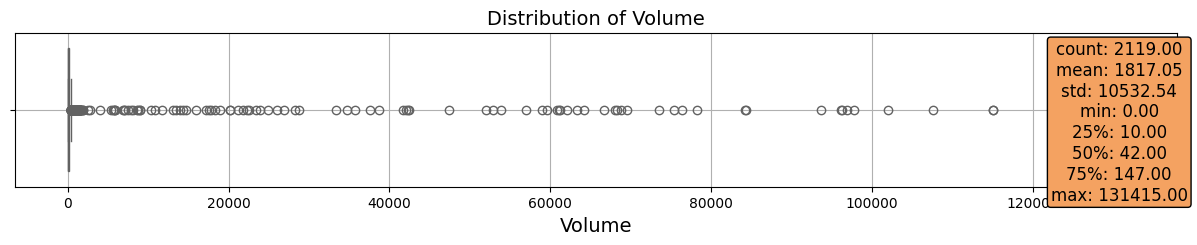

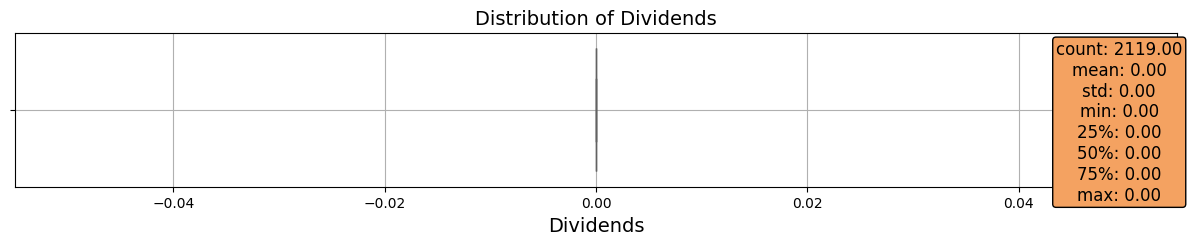

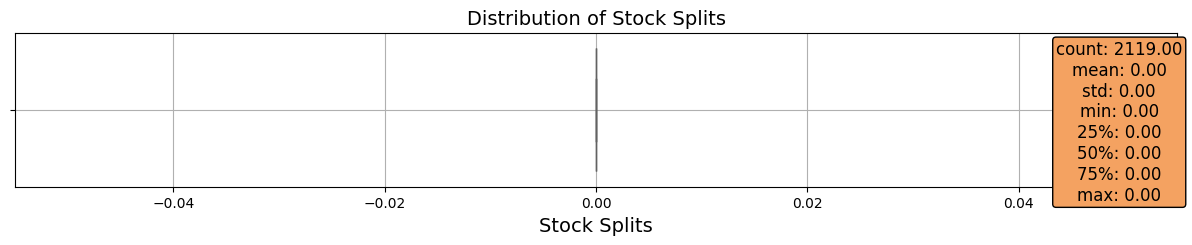

In [ ]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2))
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    stats = df[column].describe()
    stats_text = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             horizontalalignment='center', bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='#f4a261'))
    plt.grid(True)
    plt.show()

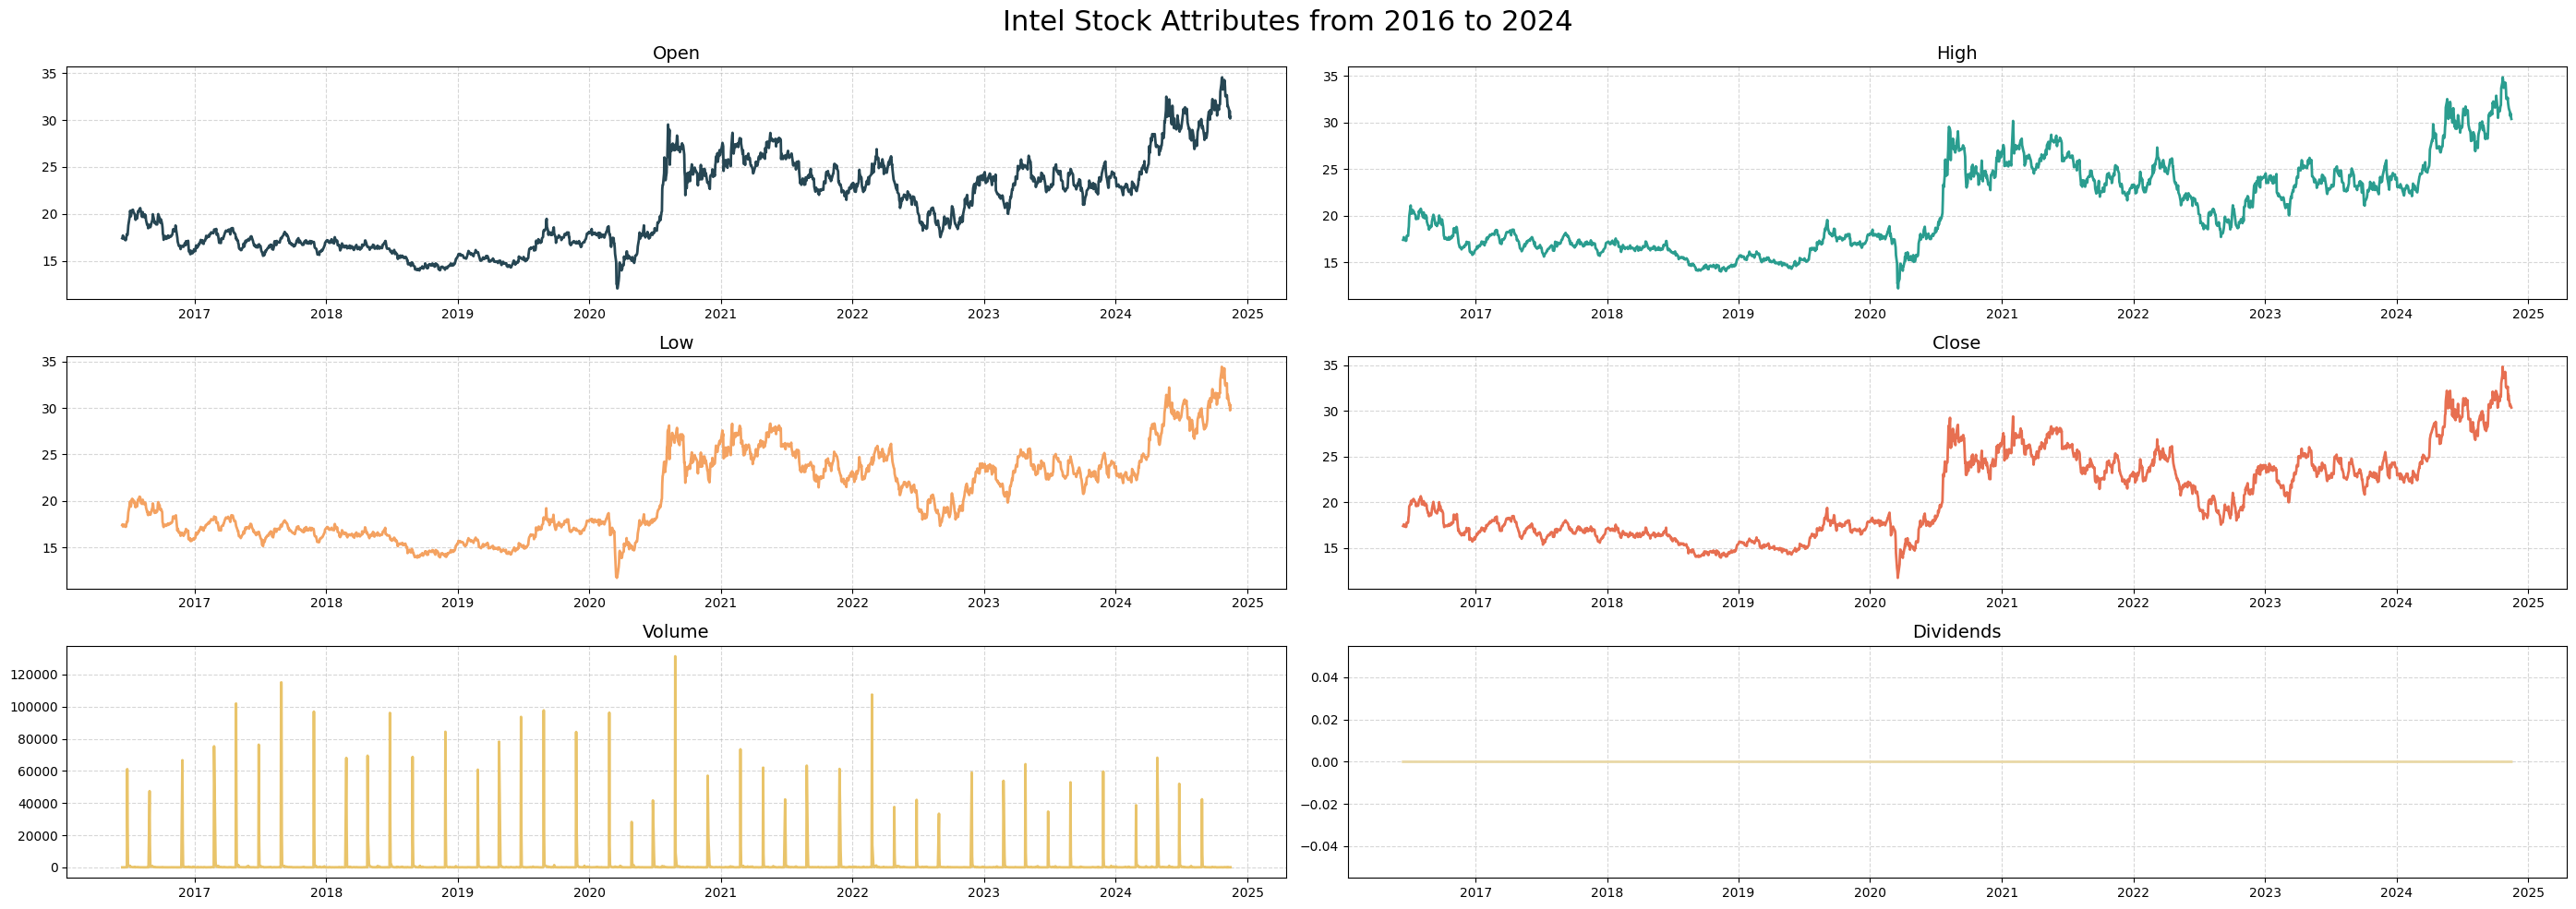

In [ ]:


import matplotlib.pyplot as plt
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.plot(x, df['Dividends'], color=colors[5], linewidth=2)
plt.title('Dividends', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Intel Stock Attributes from 2016 to 2024', fontsize=22, y=0.98)
plt.tight_layout()
plt.show()

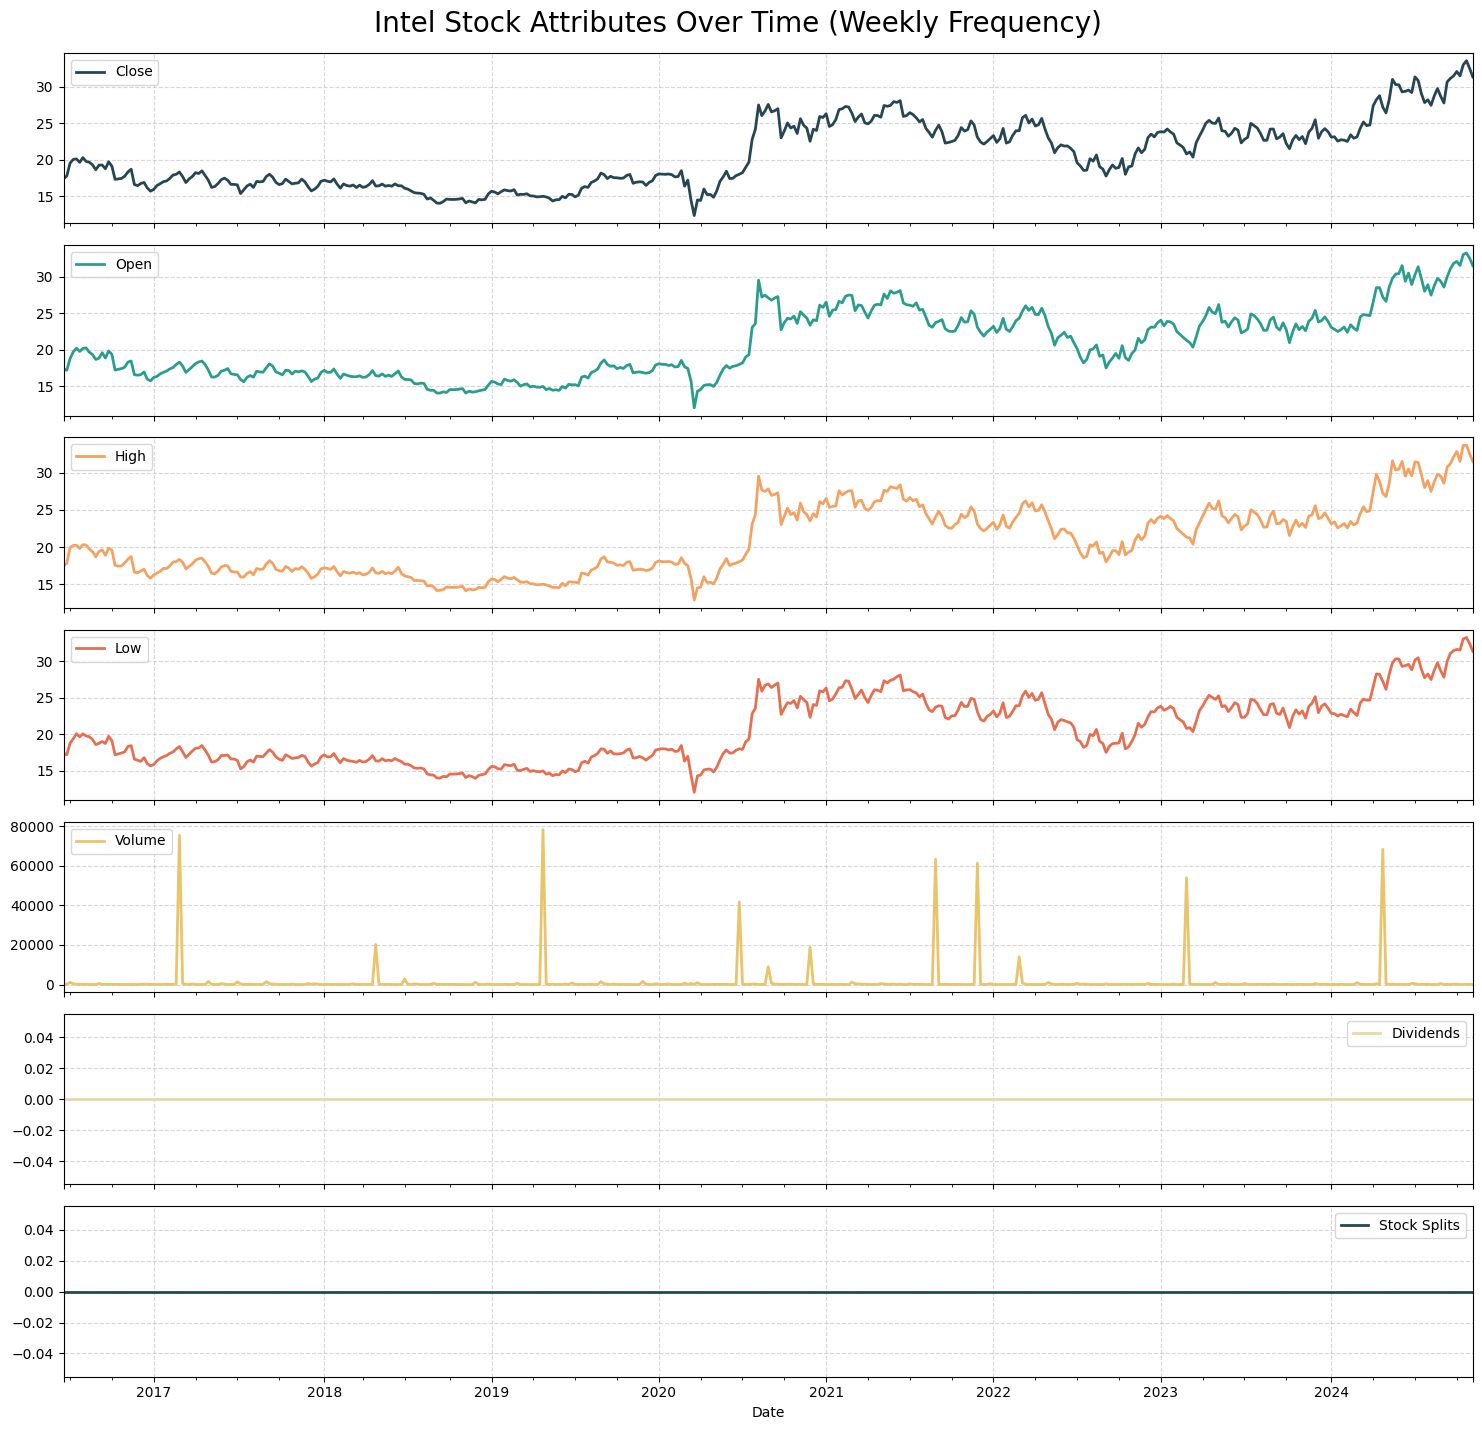

In [ ]:
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51', '#e9c46a', '#e9d8a6']
df_weekly = df.asfreq('W', method='ffill')
df_weekly.plot(subplots=True, figsize=(15, 15), style='-', color=colors, linewidth=2)
plt.suptitle('Intel Stock Attributes Over Time (Weekly Frequency)', fontsize=20, y=0.95)
for ax in plt.gcf().get_axes():
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(ax.get_title(), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

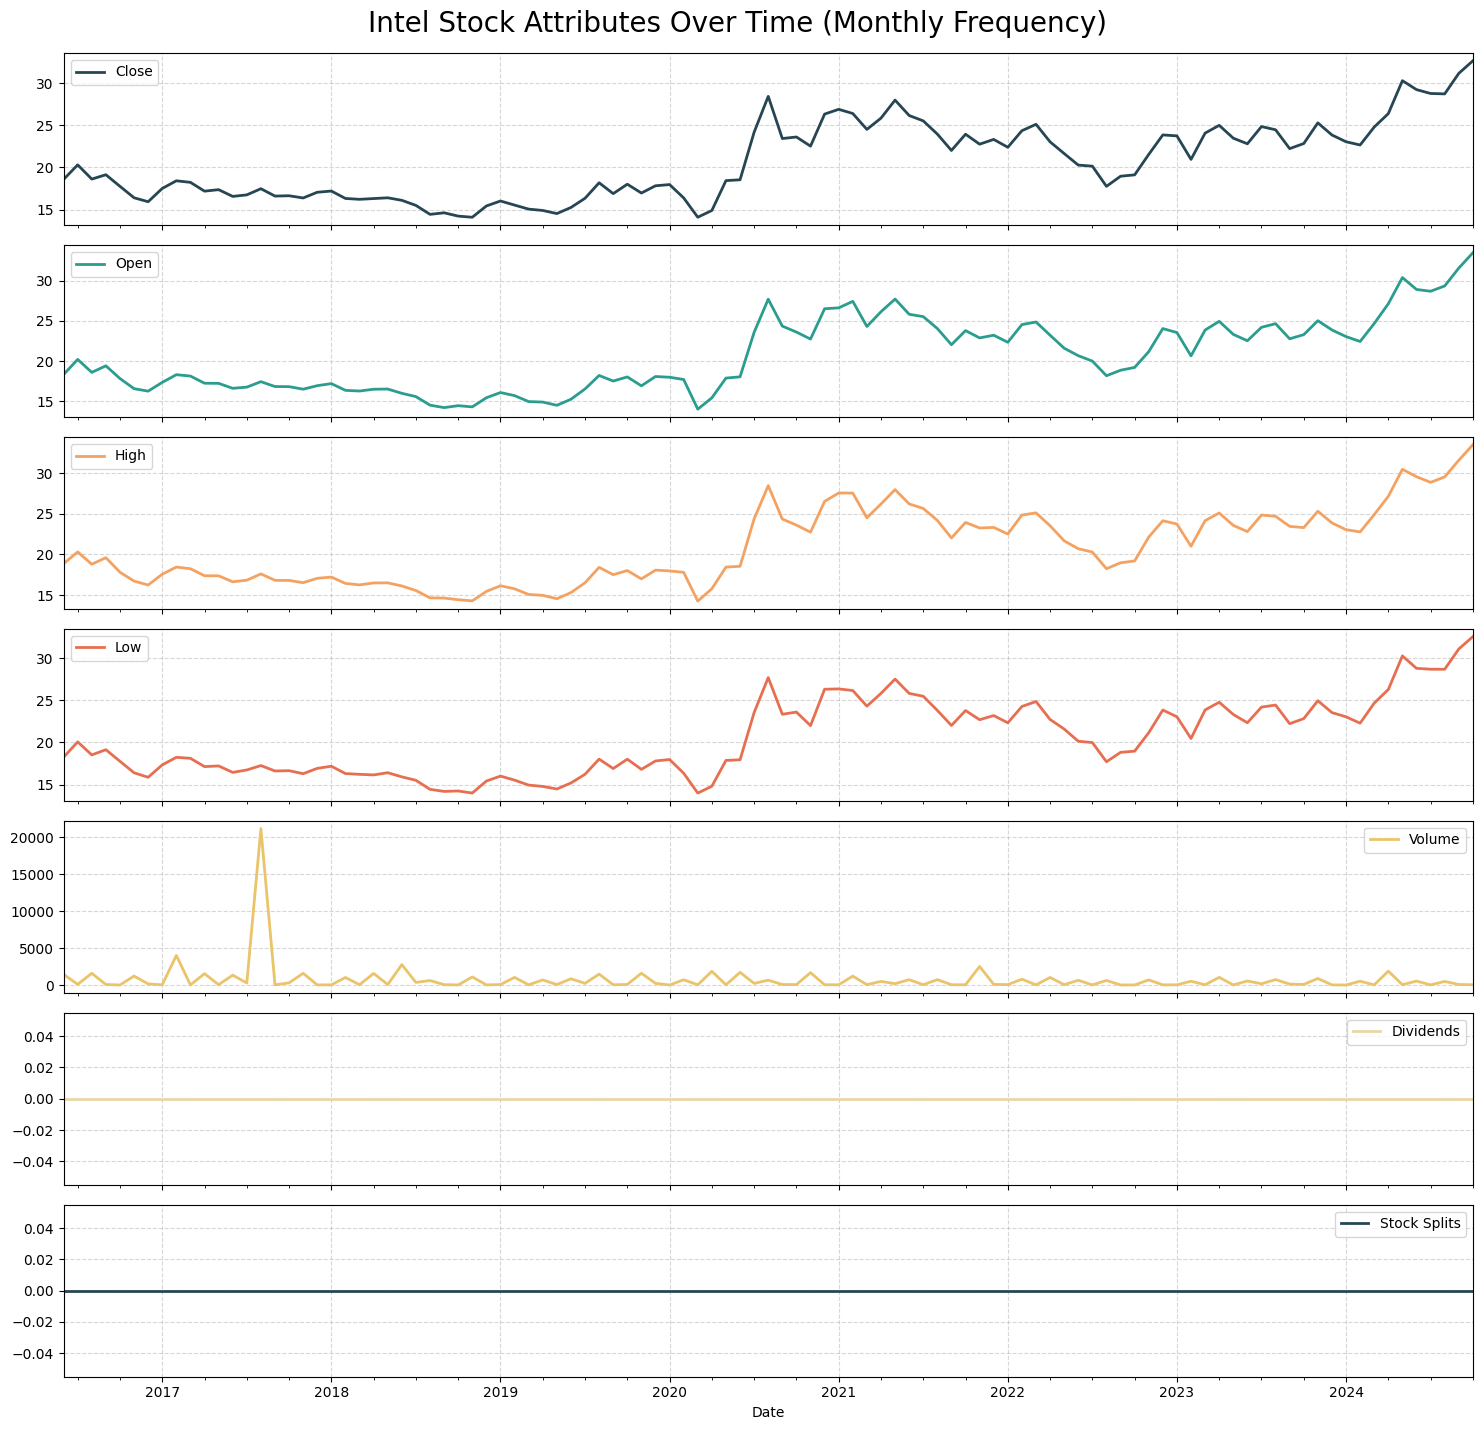

In [ ]:
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51', '#e9c46a', '#e9d8a6']
df_weekly = df.asfreq('M', method='ffill')
df_weekly.plot(subplots=True, figsize=(15, 15), style='-', color=colors, linewidth=2)
plt.suptitle('Intel Stock Attributes Over Time (Monthly Frequency)', fontsize=20, y=0.95)
for ax in plt.gcf().get_axes():
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(ax.get_title(), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# trace for candlestick chart
candletrace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick',
    increasing=dict(line=dict(color='#2a9d8f')),
    decreasing=dict(line=dict(color='#f4a261')))
# layout for the chart with custom colors
layout = go.Layout(
    title='NVDA Candlestick Chart',
    xaxis=dict(title='Date', color='#2a9d8f'),
    yaxis=dict(title='Price', color='#2a9d8f', rangemode='normal'),
    plot_bgcolor='rgba(0,0,0,0)',  # transparent background
    paper_bgcolor='rgba(255,255,255,0.85)')  # slight transparency on paper background)
# creating the figure
fig = go.Figure(data=[candletrace], layout=layout)
# removing the range slider and showing the figure
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

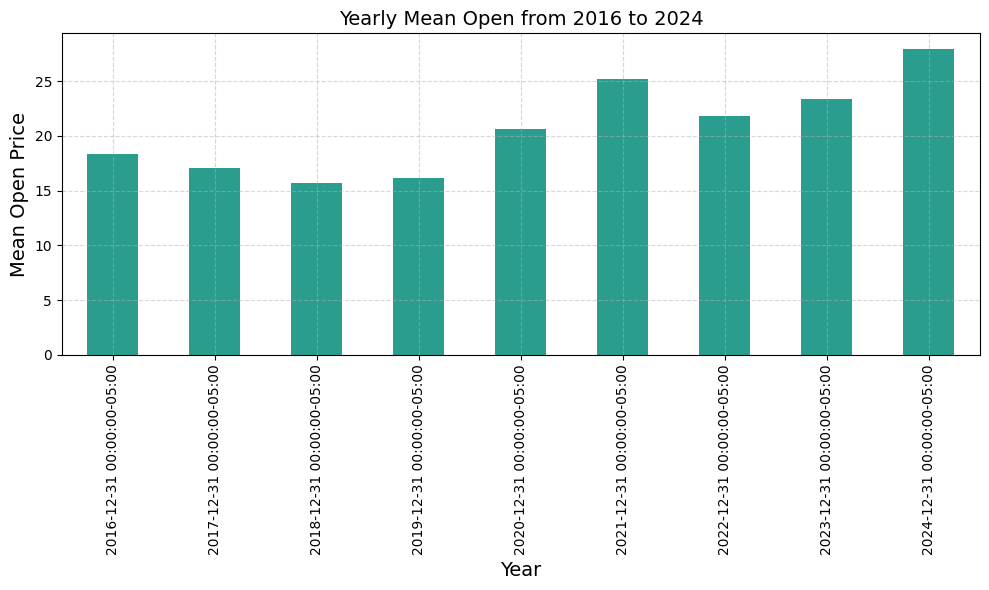

In [ ]:
import math
import yfinance as yf
import datetime as dt
# Resampling the 'Open' data by year-end and plotting the mean values
plt.figure(figsize=(10, 6))  # Set figure size
df['Open'].resample('A').mean().plot(kind='bar', color='#2a9d8f')  # Updated color
plt.title('Yearly Mean Open from 2016 to 2024', fontsize=14)  # Title with larger font
plt.xlabel('Year', fontsize=14)  # X-axis label with larger font
plt.ylabel('Mean Open Price', fontsize=14)  # Y-axis label with larger font
plt.grid(True, linestyle='--', alpha=0.5)  # Grid with dashed lines
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

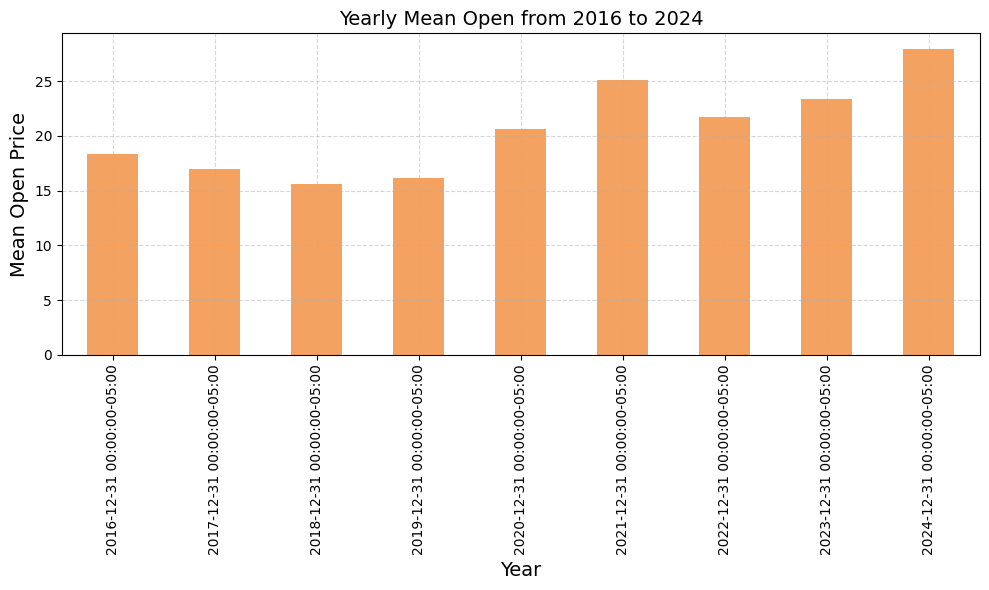

In [ ]:
plt.figure(figsize=(10, 6))
df['Close'].resample('A').mean().plot(kind='bar', color='#f4a261')
plt.title('Yearly Mean Open from 2016 to 2024', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Open Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

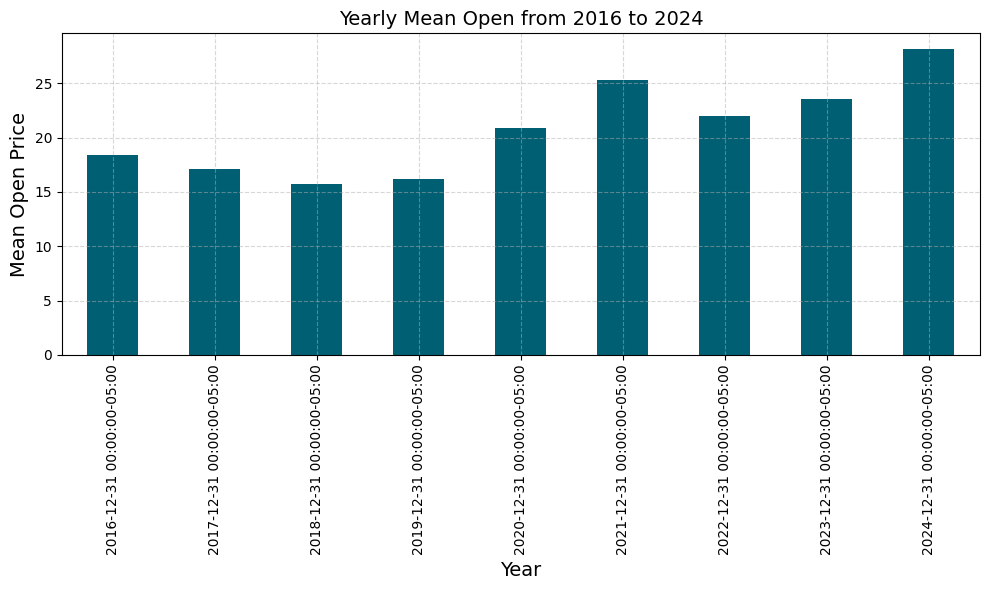

In [ ]:
plt.figure(figsize=(10, 6))
df['High'].resample('A').mean().plot(kind='bar', color='#005f73')
plt.title('Yearly Mean Open from 2016 to 2024', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Open Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

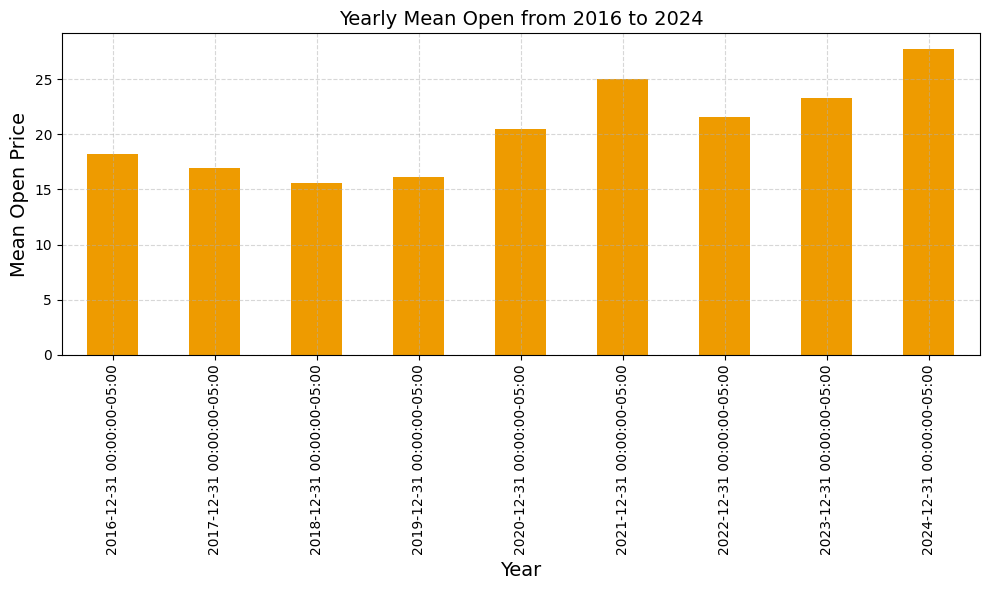

In [ ]:
plt.figure(figsize=(10, 6))
df['Low'].resample('A').mean().plot(kind='bar', color='#ee9b00')
plt.title('Yearly Mean Open from 2016 to 2024', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Open Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

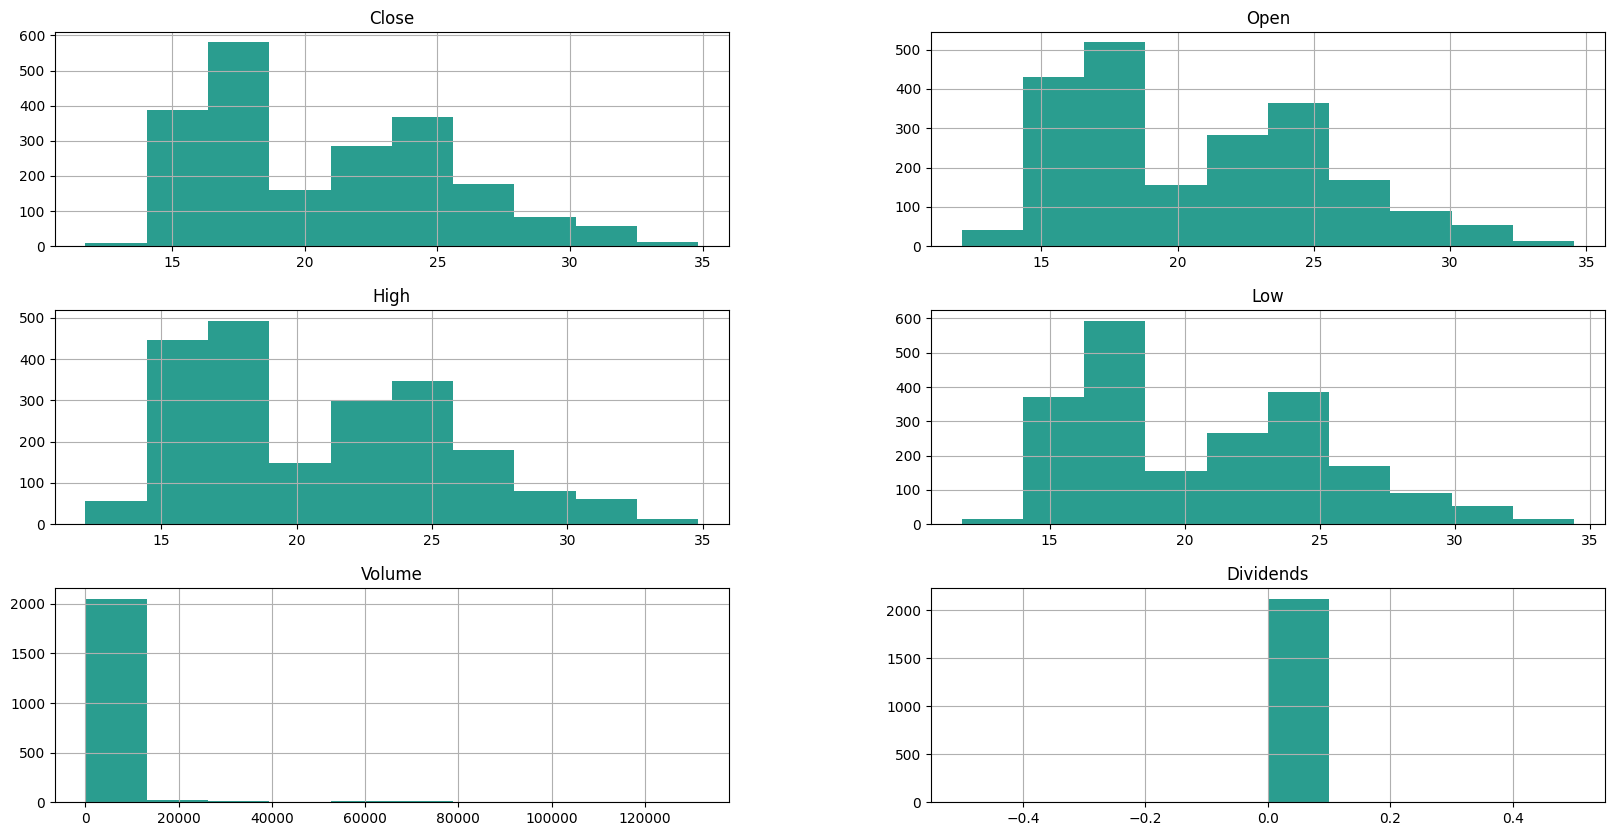

In [ ]:
df1 = df.copy()
df1.drop("Stock Splits", axis=1, inplace=True)
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
hist=df1.hist(ax = ax , color= '#2a9d8f')

In [ ]:
df[['Close']]

,Close
Date,
2016-06-14 00:00:00-04:00,17.410000
2016-06-15 00:00:00-04:00,17.489000
2016-06-16 00:00:00-04:00,17.594000
2016-06-17 00:00:00-04:00,17.400000
2016-06-20 00:00:00-04:00,17.503000
...,...
2024-11-11 00:00:00-05:00,30.540001
2024-11-12 00:00:00-05:00,30.686001
2024-11-13 00:00:00-05:00,30.590000


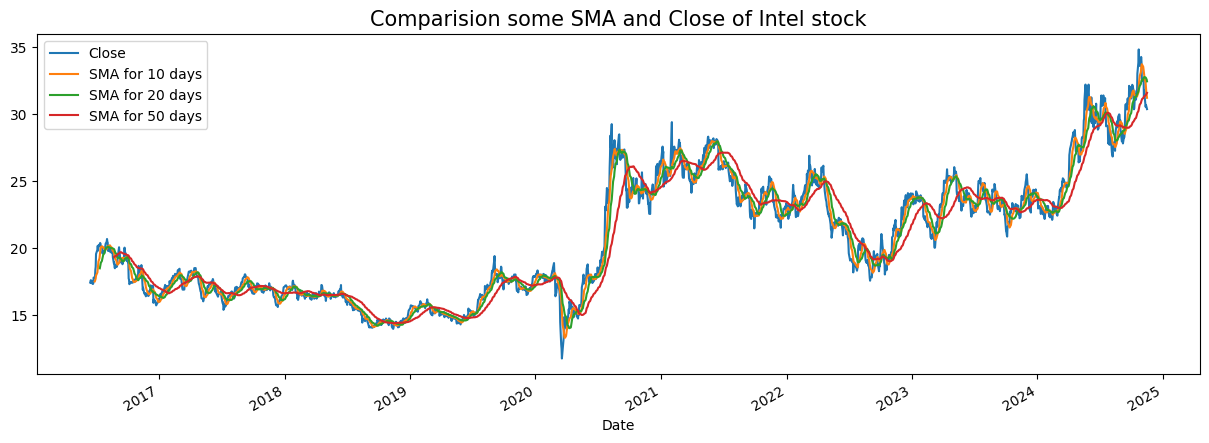

In [ ]:

md = [10, 20, 50]
for SMA in md:
    col = f'SMA for {SMA} days'
    df[col] = df['Close'].rolling(SMA).mean()
df[['Close', 'SMA for 10 days', 'SMA for 20 days', 'SMA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some SMA and Close of Intel stock', fontsize=15)
plt.show()

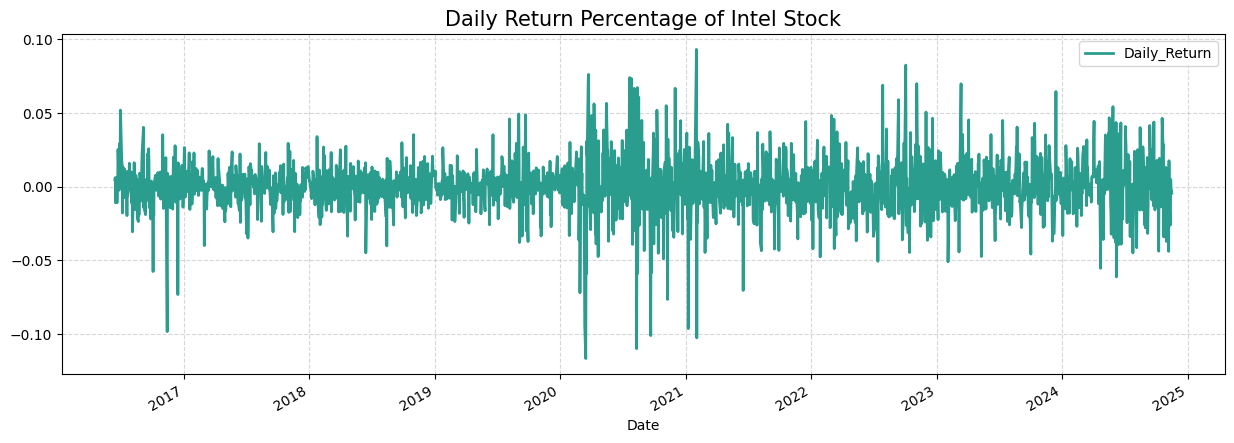

In [ ]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].plot(legend=True, figsize=(15, 5), color='#2a9d8f', linewidth=2)
plt.title('Daily Return Percentage of Intel Stock', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
df2 = df.copy(deep=True)

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling to each column individually
df2['Open'] = scaler.fit_transform(df2.Open.values.reshape(-1, 1))
df2['High'] = scaler.fit_transform(df2.High.values.reshape(-1, 1))
df2['Low'] = scaler.fit_transform(df2.Low.values.reshape(-1, 1))
df2['Close'] = scaler.fit_transform(df2.Close.values.reshape(-1, 1))
df2['Volume'] = scaler.fit_transform(df2.Volume.values.reshape(-1, 1))

# Select the relevant columns for further processing
df3 = df2[['Open', 'High', 'Low', 'Volume', 'Close']].values

# Output the shape of the resulting dataframe
df3.shape

(2119, 5)

In [ ]:
seq_len = 11
sequence = []
for index in range(len(df3) - seq_len + 1):
    sequence.append(df3[index: index + seq_len])
sequence = np.array(sequence)
print(sequence.shape)

(2109, 11, 5)


In [ ]:
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.2, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = split_data(sequence)
print("Train:", train_data.shape, "Validation:", val_data.shape, "Test:", test_data.shape)

Train: (1687, 11, 5) Validation: (211, 11, 5) Test: (211, 11, 5)


In [ ]:
x_train = train_data[:, :-1, :]
y_train = train_data[:, -1, -1]
x_valid = val_data[:, :-1, :]
y_valid = val_data[:, -1, -1]
x_test = test_data[:, :-1, :]
y_test = test_data[:, -1, -1]
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (1687, 10, 5)
y_train shape: (1687,)
x_valid shape: (211, 10, 5)
y_valid shape: (211,)
x_test shape: (211, 10, 5)
y_test shape: (211,)


In [ ]:
# Define models
def build_lstm_model():
    model = Sequential([
        LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(units=32, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

def build_multi_layer_lstm_improved():
    model = Sequential([
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
        Dropout(0.3),
        BatchNormalization(),
        Bidirectional(LSTM(units=64, return_sequences=True)),
        Dropout(0.3),
        BatchNormalization(),
        Bidirectional(LSTM(units=32, return_sequences=False)),
        Dropout(0.3),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Learning rate reduction callback
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

    return model, reduce_lr

# Usage
model, reduce_lr = build_multi_layer_lstm_improved()

In [ ]:
!pip install tensorflow
from tensorflow import keras
from keras.layers import LSTM, Dropout, Dense, SimpleRNN, GRU
from keras.models import Sequential


def build_rnn_model():
    """
    Builds a simple RNN model.
    """
    model = Sequential([
        SimpleRNN(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        SimpleRNN(units=32, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:

def build_gru_model():
    model = Sequential([
        GRU(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        GRU(units=32, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Instantiate models
model_lstm = build_lstm_model()
model_multi_layer_lstm = build_multi_layer_lstm()
model_rnn = build_rnn_model()
model_gru = build_gru_model()

# Train models
history_lstm = model_lstm.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_valid, y_valid))
history_multi_layer_lstm = model_multi_layer_lstm.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_valid, y_valid))
history_rnn = model_rnn.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_valid, y_valid))
history_gru = model_gru.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_valid, y_valid))


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0377 - val_loss: 0.0062
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

In [ ]:
y_pred_lstm = model_lstm.predict(x_test)
y_pred_multi_layer_lstm = model_multi_layer_lstm.predict(x_test)
y_pred_rnn = model_rnn.predict(x_test)
y_pred_gru = model_gru.predict(x_test)

!pip install scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,f1_score, precision_score, recall_score
import numpy as np

def evaluate_regression(y_true, y_pred, model_name):
    """
    Evaluate regression model using MSE, MAE, RMSE, and R-squared.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


In [ ]:
print("LSTM Evaluation:")
evaluate_regression(y_test, y_pred_lstm, "LSTM")
print("\nMulti-Layer LSTM Evaluation:")
evaluate_regression(y_test, y_pred_multi_layer_lstm, "Multi-Layer LSTM")
print("\nRNN Evaluation:")
evaluate_regression(y_test, y_pred_rnn, "RNN")
print("\nGRU Evaluation:")
evaluate_regression(y_test, y_pred_gru, "GRU")

# Classification metrics using an adaptive threshold
threshold = np.median(y_test)
y_true_class = (y_test >= threshold).astype(int)
y_pred_lstm_class = (y_pred_lstm.flatten() >= threshold).astype(int)
y_pred_multi_layer_lstm_class = (y_pred_multi_layer_lstm.flatten() >= threshold).astype(int)
y_pred_gru_class = (y_pred_gru.flatten() >= threshold).astype(int)
y_pred_rnn_class = (y_pred_rnn.flatten() >= threshold).astype(int)



LSTM Evaluation:
LSTM - MSE: 0.0045, MAE: 0.0496, RMSE: 0.0672, R-squared: 0.9412

Multi-Layer LSTM Evaluation:
Multi-Layer LSTM - MSE: 0.0090, MAE: 0.0693, RMSE: 0.0947, R-squared: 0.8831

RNN Evaluation:
RNN - MSE: 0.0055, MAE: 0.0562, RMSE: 0.0738, R-squared: 0.9289

GRU Evaluation:
GRU - MSE: 0.0048, MAE: 0.0506, RMSE: 0.0691, R-squared: 0.9378


In [ ]:
def evaluate_classification(y_true, y_pred_class, model_name):
    f1 = f1_score(y_true, y_pred_class, zero_division=1)
    precision = precision_score(y_true, y_pred_class, zero_division=1)
    recall = recall_score(y_true, y_pred_class, zero_division=1)
    print(f"{model_name} - F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("\nLSTM Classification Metrics:")
evaluate_classification(y_true_class, y_pred_lstm_class, "LSTM")
print("\nMulti-Layer LSTM Classification Metrics:")
evaluate_classification(y_true_class, y_pred_multi_layer_lstm_class, "Multi-Layer LSTM")
print("\nGRU Classification Metrics:")
evaluate_classification(y_true_class, y_pred_gru_class, "GRU")
print("\nRNN Classification Metrics:")
evaluate_classification(y_true_class, y_pred_rnn_class, "RNN")




LSTM Classification Metrics:
LSTM - F1 Score: 0.9474, Precision: 0.9706, Recall: 0.9252

Multi-Layer LSTM Classification Metrics:
Multi-Layer LSTM - F1 Score: 0.8808, Precision: 0.9884, Recall: 0.7944

GRU Classification Metrics:
GRU - F1 Score: 0.9423, Precision: 0.9703, Recall: 0.9159

RNN Classification Metrics:
RNN - F1 Score: 0.9320, Precision: 0.9697, Recall: 0.8972


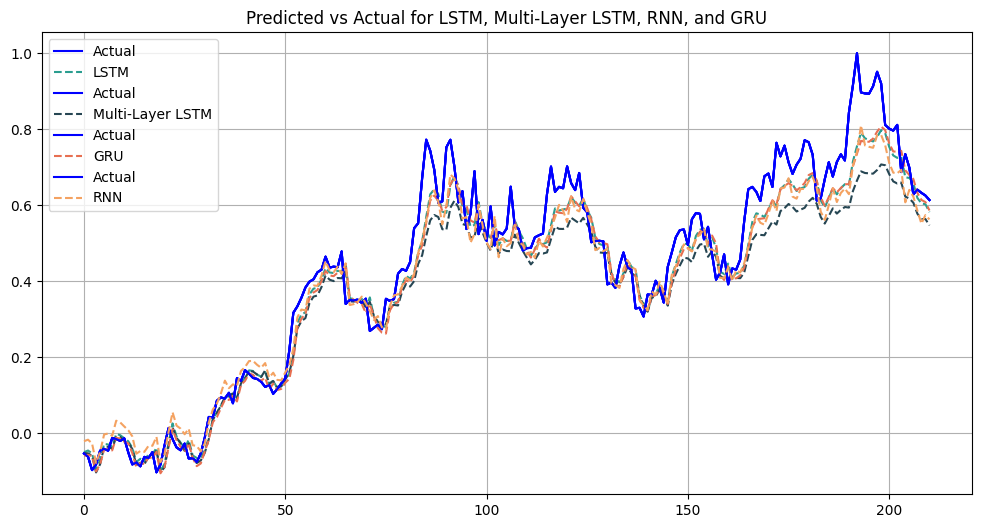

In [ ]:
# Plot actual vs. predicted values for all models
def plot_predictions(y_true, y_pred, label, color):
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred.flatten(), label=label, linestyle='--', color=color)

plt.figure(figsize=(12, 6))
plot_predictions(y_test, y_pred_lstm, 'LSTM', '#2a9d8f')
plot_predictions(y_test, y_pred_multi_layer_lstm, 'Multi-Layer LSTM', '#264653')
plot_predictions(y_test, y_pred_gru, 'GRU', '#e76f51')
plot_predictions(y_test, y_pred_rnn, 'RNN', '#f4a261')
plt.title('Predicted vs Actual for LSTM, Multi-Layer LSTM, RNN, and GRU')
plt.legend()
plt.grid(True)
plt.show()


LSTM Classification Metrics:
LSTM - F1 Score: 0.9474, Precision: 0.9706, Recall: 0.9252, Accuracy: 0.9479

Multi-Layer LSTM Classification Metrics:
Multi-Layer LSTM - F1 Score: 0.8808, Precision: 0.9884, Recall: 0.7944, Accuracy: 0.8910

GRU Classification Metrics:
GRU - F1 Score: 0.9423, Precision: 0.9703, Recall: 0.9159, Accuracy: 0.9431

RNN Classification Metrics:
RNN - F1 Score: 0.9320, Precision: 0.9697, Recall: 0.8972, Accuracy: 0.9336


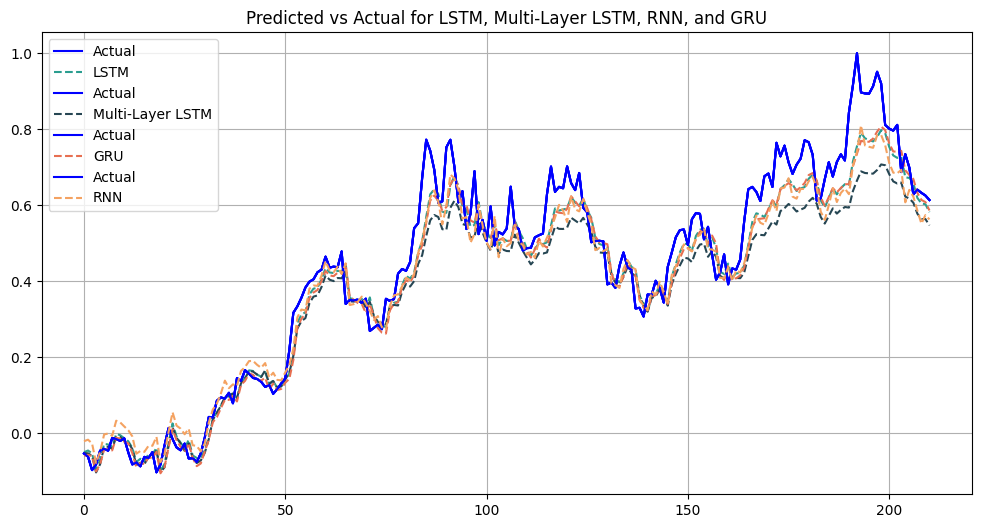

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate_classification(y_true, y_pred_class, model_name):
    f1 = f1_score(y_true, y_pred_class, zero_division=1)
    precision = precision_score(y_true, y_pred_class, zero_division=1)
    recall = recall_score(y_true, y_pred_class, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred_class)  # Calculate accuracy
    print(f"{model_name} - F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")

print("\nLSTM Classification Metrics:")
evaluate_classification(y_true_class, y_pred_lstm_class, "LSTM")
print("\nMulti-Layer LSTM Classification Metrics:")
evaluate_classification(y_true_class, y_pred_multi_layer_lstm_class, "Multi-Layer LSTM")
print("\nGRU Classification Metrics:")
evaluate_classification(y_true_class, y_pred_gru_class, "GRU")
print("\nRNN Classification Metrics:")
evaluate_classification(y_true_class, y_pred_rnn_class, "RNN")

# Plot actual vs. predicted values for all models
def plot_predictions(y_true, y_pred, label, color):
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred.flatten(), label=label, linestyle='--', color=color)

plt.figure(figsize=(12, 6))
plot_predictions(y_test, y_pred_lstm, 'LSTM', '#2a9d8f')
plot_predictions(y_test, y_pred_multi_layer_lstm, 'Multi-Layer LSTM', '#264653')
plot_predictions(y_test, y_pred_gru, 'GRU', '#e76f51')
plot_predictions(y_test, y_pred_rnn, 'RNN', '#f4a261')
plt.title('Predicted vs Actual for LSTM, Multi-Layer LSTM, RNN, and GRU')
plt.legend()
plt.grid(True)
plt.show()